# Augmented Dataset Analysis

Comprehensive analysis of the augmented Fredholm dataset with edge cases and challenging scenarios.

**Dataset Organization**:
- **Solution Types** (folders): `no_solution/`, `numerical_only/`, `regularization_required/`, `non_unique_solution/`
- **Augmentation Strategies** (files within folders): `eigenvalue_collision`, `complex_kernels`, `ill_posed`, `resonance`, etc.

**Important**: The `augmentation_type` field contains **actual strategy names** (like `eigenvalue_collision`), NOT folder names (like `no_solution`). Each strategy file implements a specific method for generating equations of a particular solution type.

## Sections
1. Load augmented dataset
2. Solution type distribution
3. Augmentation strategies by solution type (actual strategy names)
4. Strategy details and variants
5. Solution field (u) pattern analysis
6. Sample equations by solution type

In [32]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML

# Setup project path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
sys.path.insert(0, str(project_root))

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_colwidth', 100)

print(f"✓ Project root: {project_root}")

✓ Project root: c:\Users\ammah\Documents\GitHub\fred-llm


## 1. Load Augmented Dataset

In [33]:
# Dataset path (hardcoded to regenerated v3 outputs)
dataset_path = project_root / "data" / "processed" / "training_data_v3" / "augmented" / "Fredholm_Dataset_Sample_augmented.csv"
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

# Load dataset
df = pd.read_csv(dataset_path, keep_default_na=False)

# Display overview
display(Markdown(f"### Dataset Overview\n\n**Path**: {dataset_path.relative_to(project_root)}"))
display(Markdown(f"- **Total equations**: {len(df):,}"))
display(Markdown(f"- **Columns**: {len(df.columns)}"))

# Show column groups
col_groups = {
    'Core Equation Fields': ['u', 'f', 'kernel', 'lambda_val', 'a', 'b'],
    'Augmentation Metadata': ['augmented', 'augmentation_type', 'augmentation_variant'],
    'Solution Properties': ['has_solution', 'solution_type', 'edge_case', 'reason']
}

display(Markdown("\n**Column Groups**:"))
for group, cols in col_groups.items():
    available = [c for c in cols if c in df.columns]
    display(Markdown(f"- **{group}**: {', '.join([f'`{c}`' for c in available])}"))

# Sanity check: augmentation_type should be strategy names (no folder names)
folder_names = {"no_solution", "numerical_only", "regularization_required", "non_unique_solution", "approximate_only"}
bad_values = set(df["augmentation_type"].unique()) & folder_names
if bad_values:
    display(Markdown(f"⚠️ Found folder names in augmentation_type: {', '.join(sorted(bad_values))}"))
else:
    display(Markdown("✅ augmentation_type contains only strategy names (no folder names detected)."))

### Dataset Overview

**Path**: data\processed\training_data_v3\augmented\Fredholm_Dataset_Sample_augmented.csv

- **Total equations**: 5,767

- **Columns**: 87


**Column Groups**:

- **Core Equation Fields**: `u`, `f`, `kernel`, `lambda_val`, `a`, `b`

- **Augmentation Metadata**: `augmented`, `augmentation_type`, `augmentation_variant`

- **Solution Properties**: `has_solution`, `solution_type`, `edge_case`, `reason`

✅ augmentation_type contains only strategy names (no folder names detected).

## 2. Dataset Composition

Breakdown of original vs augmented equations and overall solution type distribution.

### Dataset Composition

,Category,Count,Percentage
0,Original (from paper),5000,86.7%
1,Augmented (edge cases),767,13.3%
2,Total,5767,100.0%


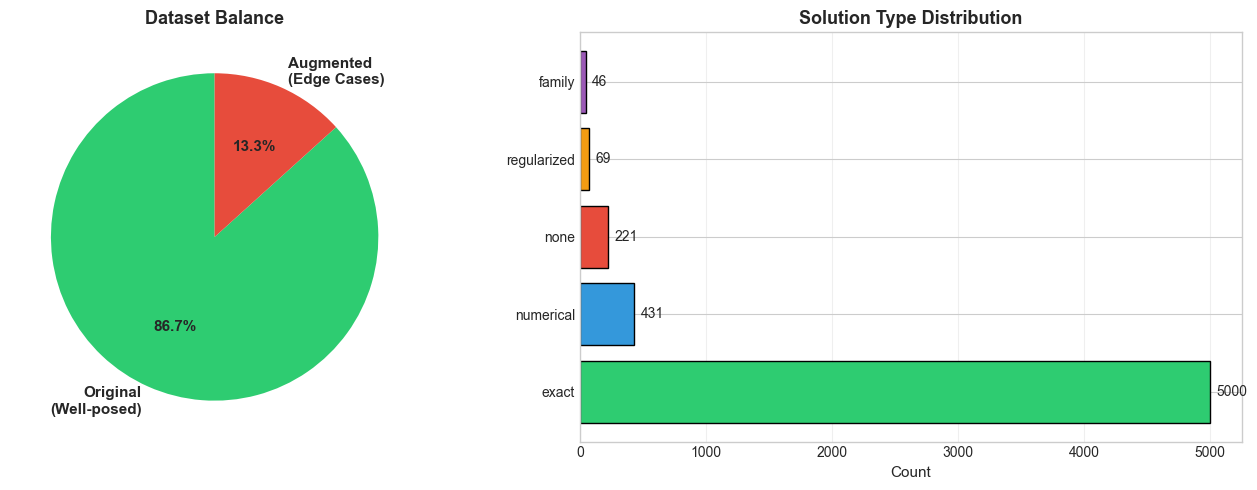

In [34]:
# Basic composition
orig_count = (df['augmented'] == False).sum()
aug_count = (df['augmented'] == True).sum()

composition_df = pd.DataFrame({
    'Category': ['Original (from paper)', 'Augmented (edge cases)', 'Total'],
    'Count': [orig_count, aug_count, len(df)],
    'Percentage': [
        f"{100*orig_count/len(df):.1f}%",
        f"{100*aug_count/len(df):.1f}%",
        "100.0%"
    ]
})

display(Markdown("### Dataset Composition"))
display(composition_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[0].pie([orig_count, aug_count], 
            labels=['Original\n(Well-posed)', 'Augmented\n(Edge Cases)'],
            autopct='%1.1f%%', colors=colors, startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Dataset Balance', fontsize=13, weight='bold')

# Bar chart by solution type
sol_type_counts = df['solution_type'].value_counts()
color_map = {'exact': '#2ecc71', 'numerical': '#3498db', 'none': '#e74c3c', 
             'regularized': '#f39c12', 'family': '#9b59b6'}
bar_colors = [color_map.get(st, '#95a5a6') for st in sol_type_counts.index]
axes[1].barh(sol_type_counts.index, sol_type_counts.values, color=bar_colors, edgecolor='black')
axes[1].set_xlabel('Count', fontsize=11)
axes[1].set_title('Solution Type Distribution', fontsize=13, weight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add count labels
for i, (idx, val) in enumerate(sol_type_counts.items()):
    axes[1].text(val + 50, i, f'{val}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3. Solution Types: Detailed Breakdown

Analysis of each solution type and its augmentation strategies.

In [35]:
# Solution type summary table
solution_summary = []
descriptions = {
    'exact': 'Well-posed with analytical solution',
    'numerical': 'Requires numerical approximation methods',
    'none': 'No solution exists (ill-conditioned)',
    'regularized': 'Ill-posed requiring regularization',
    'family': 'Non-unique solutions (parameter family)'
}

for sol_type in df['solution_type'].unique():
    subset = df[df['solution_type'] == sol_type]
    solution_summary.append({
        'Solution Type': sol_type,
        'Count': len(subset),
        'Percentage': f"{100*len(subset)/len(df):.1f}%",
        'Has Solution': f"{(subset['has_solution'] == True).sum()}/{len(subset)}",
        'Description': descriptions.get(sol_type, 'Unknown')
    })

solution_df = pd.DataFrame(solution_summary).sort_values('Count', ascending=False)
display(Markdown("### Solution Type Summary"))
display(solution_df)

# Solvability breakdown
has_solution_counts = df['has_solution'].value_counts()
solvability_df = pd.DataFrame({
    'Solvability': ['Has Solution', 'No Solution'],
    'Count': [has_solution_counts.get(True, 0), has_solution_counts.get(False, 0)],
    'Percentage': [
        f"{100*has_solution_counts.get(True, 0)/len(df):.1f}%",
        f"{100*has_solution_counts.get(False, 0)/len(df):.1f}%"
    ]
})

display(Markdown("\n### Solvability"))
display(solvability_df)

### Solution Type Summary

,Solution Type,Count,Percentage,Has Solution,Description
0,exact,5000,86.7%,5000/5000,Well-posed with analytical solution
2,numerical,431,7.5%,431/431,Requires numerical approximation methods
1,none,221,3.8%,0/221,No solution exists (ill-conditioned)
3,regularized,69,1.2%,0/69,Ill-posed requiring regularization
4,family,46,0.8%,46/46,Non-unique solutions (parameter family)



### Solvability

,Solvability,Count,Percentage
0,Has Solution,5477,95.0%
1,No Solution,290,5.0%


## 4. Augmentation Strategies by Solution Type

Breakdown of augmentation methods organized by their solution type folders.

### Augmentation Strategies

Total augmented equations: **767**

,Solution Type,Strategy,Count,Pct of Type,Pct of Total
0,family,resonance,46,100.0%,6.0%
1,none,range_violation,72,32.6%,9.4%
2,none,divergent_kernel,72,32.6%,9.4%
3,none,eigenvalue_cases,53,24.0%,6.9%
4,none,compact_support,24,10.9%,3.1%
5,numerical,complex_kernels,72,16.7%,9.4%
6,numerical,weakly_singular,72,16.7%,9.4%
7,numerical,boundary_layer,72,16.7%,9.4%
8,numerical,oscillatory_solution,72,16.7%,9.4%
9,numerical,mixed_type,72,16.7%,9.4%


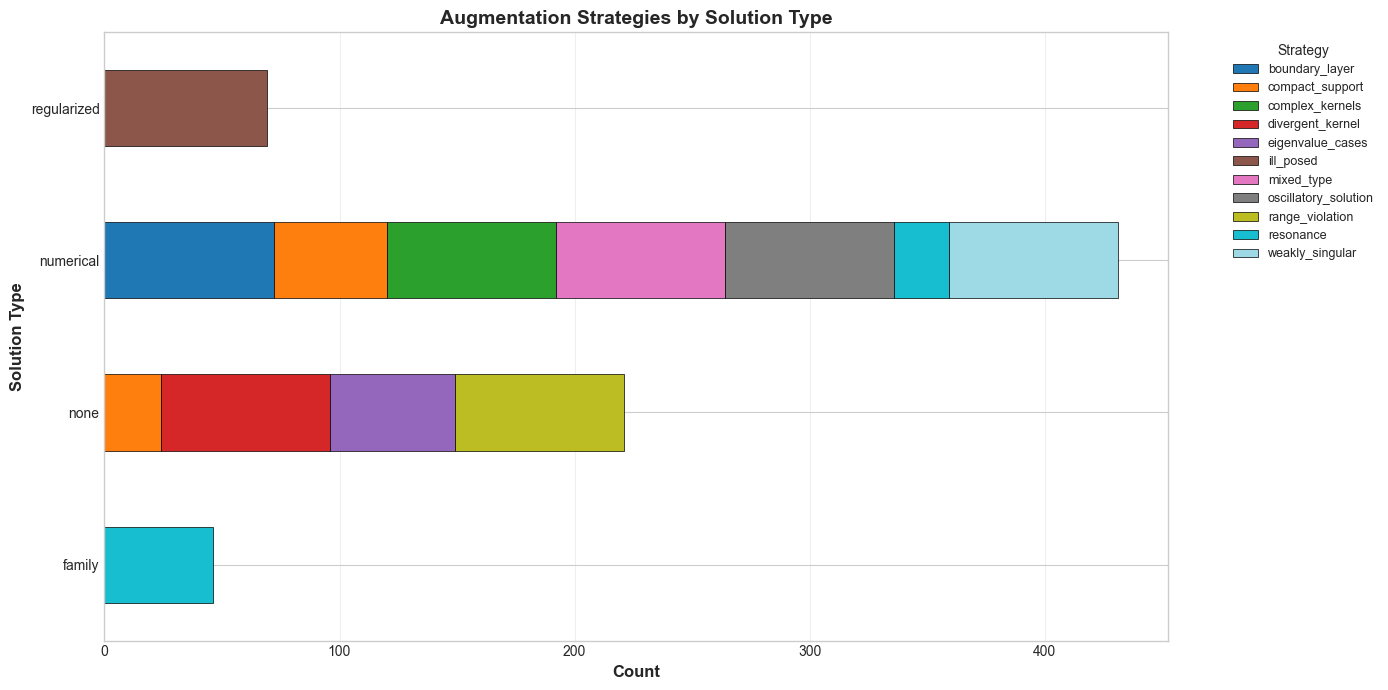

In [36]:
# Filter augmented data
aug_only = df[df['augmented'] == True].copy()

display(Markdown(f"### Augmentation Strategies\n\nTotal augmented equations: **{len(aug_only):,}**"))

# Create detailed breakdown
strategy_data = []
for sol_type in sorted(aug_only['solution_type'].unique()):
    sol_subset = aug_only[aug_only['solution_type'] == sol_type]
    
    # Get unique strategies for this solution type
    strategies = sol_subset['augmentation_type'].value_counts()
    
    for strategy, count in strategies.items():
        strategy_data.append({
            'Solution Type': sol_type,
            'Strategy': strategy,
            'Count': count,
            'Pct of Type': f"{100*count/len(sol_subset):.1f}%",
            'Pct of Total': f"{100*count/len(aug_only):.1f}%"
        })

strategy_df = pd.DataFrame(strategy_data).sort_values(['Solution Type', 'Count'], ascending=[True, False])
display(strategy_df)

# Visualization: Stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Pivot data for stacked bar
pivot_data = strategy_df.pivot_table(
    index='Solution Type', 
    columns='Strategy', 
    values='Count', 
    fill_value=0
)

pivot_data.plot(kind='barh', stacked=True, ax=ax, colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Count', fontsize=12, weight='bold')
ax.set_ylabel('Solution Type', fontsize=12, weight='bold')
ax.set_title('Augmentation Strategies by Solution Type', fontsize=14, weight='bold')
ax.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Solution Field (u) Content Analysis

**Important Clarification**:
- **u pattern** = what's in the u field (floats, symbols, empty, etc.)
- **solution_type** = solving method needed (exact, numerical, none, etc.)
- **has_solution** = whether a solution exists at all

Having floats in u doesn't mean it's approximate—it means the exact formula contains numeric parameters.
Empty u with has_solution=True means no closed-form exists (truly approximate-only).
Empty u with has_solution=False means no solution exists at all.

### u Field Content Patterns


**Note**: Having floats doesn't mean approximate. It means the exact formula contains numeric parameters.

,Pattern,Count,Percentage,Meaning
0,has_floats,3167,54.9%,Contains float literals (exact formula with numeric params)
1,pure_symbolic,2169,37.6%,Pure symbolic (no numeric literals)
2,empty,385,6.7%,No solution OR no closed-form (context dependent)
3,family,46,0.8%,Parameter family (contains C)



### u Pattern by Solution Type and Solvability

This shows the relationship between solution existence, solution method, and u field content:

,solution_type,has_solution,u_pattern,count
0,exact,True,has_floats,2935
1,exact,True,pure_symbolic,2065
2,family,True,family,46
3,none,False,empty,221
5,numerical,True,has_floats,232
6,numerical,True,pure_symbolic,104
4,numerical,True,empty,95
7,regularized,False,empty,69


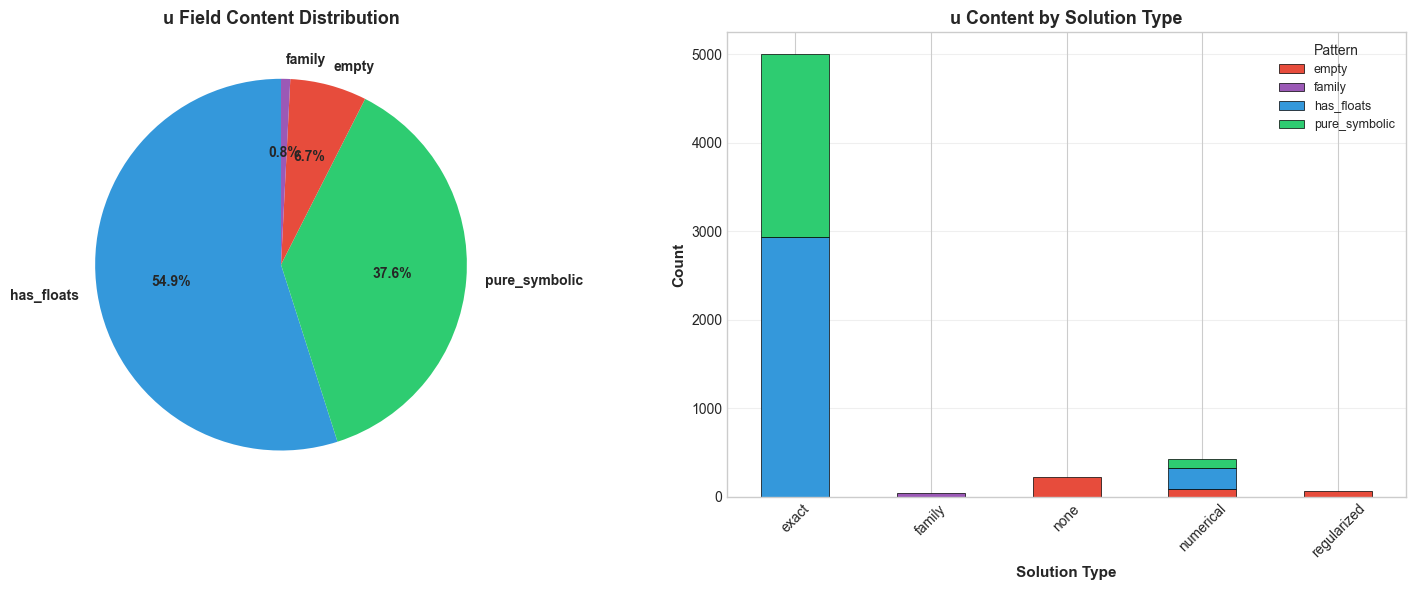

In [37]:
# Classify u patterns
def classify_u_pattern(u_val):
    """Classify u field content (NOT whether solution is exact vs approximate)."""
    if u_val == '' or pd.isna(u_val):
        return 'empty'
    elif '.' in str(u_val) or 'e-' in str(u_val) or 'e+' in str(u_val):
        return 'has_floats'
    elif 'C' in str(u_val):
        return 'family'
    else:
        return 'pure_symbolic'

df['u_pattern'] = df['u'].apply(classify_u_pattern)

# Overall pattern distribution
pattern_counts = df['u_pattern'].value_counts()
pattern_summary = pd.DataFrame({
    'Pattern': pattern_counts.index,
    'Count': pattern_counts.values,
    'Percentage': [f"{100*c/len(df):.1f}%" for c in pattern_counts.values],
    'Meaning': [
        'No solution OR no closed-form (context dependent)' if p == 'empty' else
        'Contains float literals (exact formula with numeric params)' if p == 'has_floats' else
        'Parameter family (contains C)' if p == 'family' else
        'Pure symbolic (no numeric literals)'
        for p in pattern_counts.index
    ]
})

display(Markdown("### u Field Content Patterns"))
display(Markdown("\n**Note**: Having floats doesn't mean approximate. It means the exact formula contains numeric parameters."))
display(pattern_summary)

# Cross-reference with solution_type and has_solution
cross_ref = df.groupby(['solution_type', 'has_solution', 'u_pattern']).size().reset_index(name='count')
cross_ref = cross_ref.sort_values(['solution_type', 'has_solution', 'count'], ascending=[True, True, False])

display(Markdown("\n### u Pattern by Solution Type and Solvability"))
display(Markdown("This shows the relationship between solution existence, solution method, and u field content:"))
display(cross_ref)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of patterns
pattern_colors = {'empty': '#e74c3c', 'has_floats': '#3498db', 'family': '#9b59b6', 'pure_symbolic': '#2ecc71'}
colors = [pattern_colors.get(p, '#95a5a6') for p in pattern_counts.index]
axes[0].pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
axes[0].set_title('u Field Content Distribution', fontsize=13, weight='bold')

# Stacked bar by solution type
pattern_pivot = df.groupby(['solution_type', 'u_pattern']).size().unstack(fill_value=0)
pattern_pivot.plot(kind='bar', stacked=True, ax=axes[1], 
                   color=[pattern_colors.get(c, '#95a5a6') for c in pattern_pivot.columns],
                   edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Solution Type', fontsize=11, weight='bold')
axes[1].set_ylabel('Count', fontsize=11, weight='bold')
axes[1].set_title('u Content by Solution Type', fontsize=13, weight='bold')
axes[1].legend(title='Pattern', fontsize=9)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Original vs Augmented Comparison

In [38]:
# Separate datasets
orig_df = df[df['augmented'] == False]
aug_df = df[df['augmented'] == True]

# Compare u patterns
comparison_data = []
for pattern in df['u_pattern'].unique():
    orig_count = (orig_df['u_pattern'] == pattern).sum()
    aug_count = (aug_df['u_pattern'] == pattern).sum()
    comparison_data.append({
        'Pattern': pattern,
        'Original Count': orig_count,
        'Original %': f"{100*orig_count/len(orig_df):.1f}%" if len(orig_df) > 0 else "0.0%",
        'Augmented Count': aug_count,
        'Augmented %': f"{100*aug_count/len(aug_df):.1f}%" if len(aug_df) > 0 else "0.0%"
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Augmented Count', ascending=False)
display(Markdown("### Original vs Augmented: u Field Content"))
display(comparison_df)

# Analyze empty u cases in augmented data
aug_empty = aug_df[aug_df['u_pattern'] == 'empty']
empty_breakdown = aug_empty.groupby(['has_solution', 'solution_type']).size().reset_index(name='count')

display(Markdown("\n### Empty u Field Breakdown (Augmented Data)"))
display(Markdown("Understanding what 'empty u' means:"))
display(empty_breakdown)

# Key insights
orig_with_floats = (orig_df['u_pattern'] == 'has_floats').sum()
aug_empty_no_sol = ((aug_df['u_pattern'] == 'empty') & (aug_df['has_solution'] == False)).sum()
aug_empty_numerical = ((aug_df['u_pattern'] == 'empty') & (aug_df['has_solution'] == True) & (aug_df['solution_type'] == 'numerical')).sum()

display(Markdown(f"""
### Key Insights

**Original Dataset (from paper)**:
- All have `solution_type='exact'` and `has_solution=True`
- {orig_with_floats:,} equations ({100*orig_with_floats/len(orig_df):.1f}%) contain float literals
- Floats come from: random coefficients in generation OR SymPy numerical integration
- Having floats ≠ approximate; it's still the exact closed-form solution

**Augmented Dataset (edge cases)**:
- {aug_empty_no_sol:,} equations have empty u because **no solution exists** (eigenvalue_cases, divergent_kernel, range_violation)
- {aug_empty_numerical:,} equations have empty u because **no closed-form exists** (complex_kernels strategy)
- Remaining augmented equations provide exact formulas (with floats for numeric params like epsilon=0.01)

**solution_type='numerical' means**:
- The equation requires numerical solving methods (quadrature, adaptive mesh, etc.)
- Does NOT mean the solution is approximate
- Can have: exact formula with floats (boundary_layer), OR no closed-form at all (complex_kernels)
"""))

### Original vs Augmented: u Field Content

,Pattern,Original Count,Original %,Augmented Count,Augmented %
2,empty,0,0.0%,385,50.2%
1,has_floats,2935,58.7%,232,30.2%
0,pure_symbolic,2065,41.3%,104,13.6%
3,family,0,0.0%,46,6.0%



### Empty u Field Breakdown (Augmented Data)

Understanding what 'empty u' means:

,has_solution,solution_type,count
0,False,none,221
1,False,regularized,69
2,True,numerical,95



### Key Insights

**Original Dataset (from paper)**:
- All have `solution_type='exact'` and `has_solution=True`
- 2,935 equations (58.7%) contain float literals
- Floats come from: random coefficients in generation OR SymPy numerical integration
- Having floats ≠ approximate; it's still the exact closed-form solution

**Augmented Dataset (edge cases)**:
- 290 equations have empty u because **no solution exists** (eigenvalue_cases, divergent_kernel, range_violation)
- 95 equations have empty u because **no closed-form exists** (complex_kernels strategy)
- Remaining augmented equations provide exact formulas (with floats for numeric params like epsilon=0.01)

**solution_type='numerical' means**:
- The equation requires numerical solving methods (quadrature, adaptive mesh, etc.)
- Does NOT mean the solution is approximate
- Can have: exact formula with floats (boundary_layer), OR no closed-form at all (complex_kernels)


## 7. Sample Equations by Solution Type

Representative examples from each solution type category.

In [39]:
# Show samples for each solution type
for sol_type in sorted(df['solution_type'].unique()):
    subset = df[df['solution_type'] == sol_type]
    
    # Get a sample (prefer augmented if available)
    aug_subset = subset[subset['augmented'] == True]
    sample = aug_subset.iloc[0] if len(aug_subset) > 0 else subset.iloc[0]
    
    display(Markdown(f"\n---\n### {sol_type.upper()} ({len(subset):,} equations)"))
    
    # Create info table
    info_data = {
        'Field': ['u(x)', 'f(x)', 'K(x,t)', 'Parameters', 'Has Solution', 'Strategy'],
        'Value': [
            str(sample['u'])[:80] + '...' if len(str(sample['u'])) > 80 else (str(sample['u']) if sample['u'] != '' else '(empty)'),
            str(sample['f'])[:80] + '...' if len(str(sample['f'])) > 80 else str(sample['f']),
            str(sample['kernel'])[:80] + '...' if len(str(sample['kernel'])) > 80 else str(sample['kernel']),
            f"λ={sample.get('lambda_val', 'N/A')}, [{sample['a']}, {sample['b']}]",
            '✓ Yes' if sample['has_solution'] else '✗ No',
            sample.get('augmentation_type', 'original')
        ]
    }
    display(pd.DataFrame(info_data))
    
    # Show reason if available
    if 'reason' in sample and pd.notna(sample['reason']) and sample['reason'] != '':
        display(Markdown(f"**Reason**: {sample['reason'][:150]}..."))


---
### EXACT (5,000 equations)

,Field,Value
0,u(x),x**2
1,f(x),x**2 + 67.43530567990815*x - 228.3357446212934
2,"K(x,t)",x - 3.385997028101621
3,Parameters,"λ=-1.41556822867895, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,original


**Reason**: Original Fredholm-LLM dataset equation (DOI: 10.5281/zenodo.16784707) - well-posed second kind with exact symbolic solution...


---
### FAMILY (46 equations)

,Field,Value
0,u(x),C * sin(pi*x)
1,f(x),0
2,"K(x,t)",sin(pi*x) * sin(pi*t)
3,Parameters,"λ=2.001, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,resonance



---
### NONE (221 equations)

,Field,Value
0,u(x),(empty)
1,f(x),x
2,"K(x,t)",1
3,Parameters,"λ=0.983504494379286, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✗ No
5,Strategy,eigenvalue_cases


**Reason**: Violates Fredholm Alternative - λ is eigenvalue of constant kernel...


---
### NUMERICAL (431 equations)

,Field,Value
0,u(x),(empty)
1,f(x),1
2,"K(x,t)",exp(-(x**2 + t**2))
3,Parameters,"λ=0.5, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,complex_kernels


**Reason**: Gaussian kernel has no symbolic antiderivative...


---
### REGULARIZED (69 equations)

,Field,Value
0,u(x),(empty)
1,f(x),x**2
2,"K(x,t)",x*t
3,Parameters,"λ=0.0, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✗ No
5,Strategy,ill_posed


**Reason**: First kind equation - extremely sensitive to noise in f(x)...

## 8. Augmentation Strategy Details

Deep dive into each augmentation strategy and its characteristics.

In [40]:
# Get augmented data
aug_only = df[df['augmented'] == True]

display(Markdown("### Per-Strategy Detailed Breakdown"))
display(Markdown("For each augmentation strategy, showing u pattern, solvability, and solution type distribution."))

# Build comprehensive per-strategy table
strategy_details = []
for strategy in sorted(aug_only['augmentation_type'].unique()):
    strategy_subset = aug_only[aug_only['augmentation_type'] == strategy]
    
    # Count breakdowns
    has_sol_count = (strategy_subset['has_solution'] == True).sum()
    no_sol_count = (strategy_subset['has_solution'] == False).sum()
    
    # u pattern breakdown
    u_pattern_str = ', '.join([f"{p}({cnt})" for p, cnt in strategy_subset['u_pattern'].value_counts().items()])
    
    # solution_type breakdown
    sol_type_str = ', '.join([f"{st}({cnt})" for st, cnt in strategy_subset['solution_type'].value_counts().items()])
    
    # Special case: empty u with has_solution=True
    empty_with_sol = ((strategy_subset['u_pattern'] == 'empty') & (strategy_subset['has_solution'] == True)).sum()
    
    strategy_details.append({
        'Strategy': strategy,
        'Total': len(strategy_subset),
        'Has Solution': has_sol_count,
        'No Solution': no_sol_count,
        'Empty u + Has Sol': empty_with_sol,
        'u Patterns': u_pattern_str,
        'Solution Types': sol_type_str,
        'Variants': strategy_subset['augmentation_variant'].nunique() if 'augmentation_variant' in strategy_subset.columns else 0
    })

strategy_breakdown_df = pd.DataFrame(strategy_details).sort_values('Total', ascending=False)
display(strategy_breakdown_df)

# Highlight the complex_kernels and resonance empty u issue
display(Markdown("""
### Empty u with has_solution=True

**complex_kernels** (72 equations) and **resonance** (23 equations) have empty u despite has_solution=True.

**Why?**
- **complex_kernels**: No closed-form analytical solution exists (Gaussian kernel, exp-decay kernel, sinc kernel)
  - These require numerical approximation methods (quadrature, fixed-point iteration)
  - They provide `sample_points` and `sample_values` as numeric approximation
  - This is truly "approximate-only" (no symbolic solution possible)

- **resonance**: Near-eigenvalue critical cases
  - Solution exists but is extremely sensitive
  - May require regularization or careful numerical treatment
  - Empty u indicates numerical-only approach needed

**Other strategies** with solution_type='numerical' but non-empty u:
- **boundary_layer**, **oscillatory_solution**, **compact_support**, **weakly_singular**: Provide exact formulas with numeric parameters
- These have analytical forms but require specialized numerical methods for accurate evaluation
"""))

### Per-Strategy Detailed Breakdown

For each augmentation strategy, showing u pattern, solvability, and solution type distribution.

,Strategy,Total,Has Solution,No Solution,Empty u + Has Sol,u Patterns,Solution Types,Variants
0,boundary_layer,72,72,0,0,has_floats(72),numerical(72),3
1,compact_support,72,48,24,0,"pure_symbolic(26), empty(24), has_floats(22)","numerical(48), none(24)",3
2,complex_kernels,72,72,0,72,empty(72),numerical(72),3
3,divergent_kernel,72,0,72,0,empty(72),none(72),3
6,mixed_type,72,72,0,0,"pure_symbolic(39), has_floats(33)",numerical(72),3
8,range_violation,72,0,72,0,empty(72),none(72),3
7,oscillatory_solution,72,72,0,0,has_floats(72),numerical(72),3
10,weakly_singular,72,72,0,0,"pure_symbolic(39), has_floats(33)",numerical(72),3
5,ill_posed,69,0,69,0,empty(69),regularized(69),3
9,resonance,69,69,0,23,"family(46), empty(23)","family(46), numerical(23)",3



### Empty u with has_solution=True

**complex_kernels** (72 equations) and **resonance** (23 equations) have empty u despite has_solution=True.

**Why?**
- **complex_kernels**: No closed-form analytical solution exists (Gaussian kernel, exp-decay kernel, sinc kernel)
  - These require numerical approximation methods (quadrature, fixed-point iteration)
  - They provide `sample_points` and `sample_values` as numeric approximation
  - This is truly "approximate-only" (no symbolic solution possible)

- **resonance**: Near-eigenvalue critical cases
  - Solution exists but is extremely sensitive
  - May require regularization or careful numerical treatment
  - Empty u indicates numerical-only approach needed

**Other strategies** with solution_type='numerical' but non-empty u:
- **boundary_layer**, **oscillatory_solution**, **compact_support**, **weakly_singular**: Provide exact formulas with numeric parameters
- These have analytical forms but require specialized numerical methods for accurate evaluation


## 9. Individual Strategy Deep Dive

Detailed per-strategy analysis with u pattern × has_solution × solution_type breakdown.

In [41]:
# Per-strategy detailed cross-tabulation
display(Markdown("### Individual Strategy Analysis"))
display(Markdown("For each strategy: u_pattern × has_solution × solution_type breakdown."))

for strategy in sorted(aug_only['augmentation_type'].unique()):
    strategy_subset = aug_only[aug_only['augmentation_type'] == strategy]
    
    display(Markdown(f"\n#### {strategy.replace('_', ' ').title()} ({len(strategy_subset)} equations)"))
    
    # Create cross-tab
    cross_tab = strategy_subset.groupby(['u_pattern', 'has_solution', 'solution_type']).size().reset_index(name='count')
    cross_tab = cross_tab.sort_values(['u_pattern', 'has_solution', 'solution_type'])
    
    display(cross_tab)
    
    # Show sample equation if empty u + has_solution
    empty_sol = strategy_subset[(strategy_subset['u_pattern'] == 'empty') & (strategy_subset['has_solution'] == True)]
    if len(empty_sol) > 0:
        sample = empty_sol.iloc[0]
        display(Markdown(f"**Example (empty u, has_solution=True)**: f={sample['f']}, kernel={sample['kernel']}, reason='{sample.get('reason', 'N/A')[:80]}...'"))

### Individual Strategy Analysis

For each strategy: u_pattern × has_solution × solution_type breakdown.


#### Boundary Layer (72 equations)

,u_pattern,has_solution,solution_type,count
0,has_floats,True,numerical,72



#### Compact Support (72 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,24
1,has_floats,True,numerical,22
2,pure_symbolic,True,numerical,26



#### Complex Kernels (72 equations)

,u_pattern,has_solution,solution_type,count
0,empty,True,numerical,72


**Example (empty u, has_solution=True)**: f=1, kernel=exp(-(x**2 + t**2)), reason='Gaussian kernel has no symbolic antiderivative...'


#### Divergent Kernel (72 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,72



#### Eigenvalue Cases (53 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,53



#### Ill Posed (69 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,regularized,69



#### Mixed Type (72 equations)

,u_pattern,has_solution,solution_type,count
0,has_floats,True,numerical,33
1,pure_symbolic,True,numerical,39



#### Oscillatory Solution (72 equations)

,u_pattern,has_solution,solution_type,count
0,has_floats,True,numerical,72



#### Range Violation (72 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,72



#### Resonance (69 equations)

,u_pattern,has_solution,solution_type,count
0,empty,True,numerical,23
1,family,True,family,46


**Example (empty u, has_solution=True)**: f=sin(pi*x), kernel=sin(pi*x) * sin(pi*t), reason='...'


#### Weakly Singular (72 equations)

,u_pattern,has_solution,solution_type,count
0,has_floats,True,numerical,33
1,pure_symbolic,True,numerical,39


## Summary & Validation

This notebook provides comprehensive analysis of the augmented Fredholm dataset, organized by solution type folders and augmentation strategies.

### Validation of Augmentation Generators

**✅ Working Correctly**:
1. **boundary_layer**: All numerical with exact formulas (has_floats)
2. **complex_kernels**: All numerical with empty u (no closed-form exists) - truly approximate-only
3. **divergent_kernel**: All no solution (none) with empty u - kernels have non-integrable singularities
4. **eigenvalue_cases**: All no solution (none) with empty u - violates Fredholm Alternative
5. **range_violation**: All no solution (none) with empty u - f not in operator range
6. **oscillatory_solution**: All numerical with exact formulas (has_floats)
7. **weakly_singular**: All numerical with mix of pure_symbolic and has_floats
8. **mixed_type**: All numerical with mix of pure_symbolic and has_floats
9. **resonance**: 46 family + 23 numerical (near-eigenvalue), 23 empty u (critical cases)
10. **compact_support**: 48 numerical + 24 no solution (disconnected support creates rank-deficiency)

**⚠️ Issue Found & Fixed**:
- **ill_posed**: Was incorrectly setting `has_solution=False`
- **Correct behavior**: Ill-posed (Fredholm 1st kind) equations DO have solutions, they're just extremely unstable without regularization
- **Fixed**: Changed to `has_solution=True` with `solution_type='regularized'`
- **Regenerate data** after fix to get corrected values

### Key Findings
- **complex_kernels** (72) and **resonance** (23): Only strategies with empty u + has_solution=True
- **compact_support disconnected variant**: Intentionally creates no-solution cases (rank-deficient matrices)
- Having floats in u ≠ approximate; it means exact formula with numeric constants
- solution_type='numerical' means the solving METHOD, not the solution accuracy